In [1]:
import os

import pandas as pd
import numpy as np

import scienceplots
import matplotlib.pyplot as plt
plt.style.use("science")

import gaiaxpy
import astropy.visualization
import astropy.units as u
from astropy.table import Table

BASE_DATA_DIR = "/home/ramon/uanl/thesis/Backup Data/Gaia Spectra"
SPECTRA_ECSV_PATH = os.path.join(BASE_DATA_DIR, "XP_CONTINUOUS-Gaia DR3 1982536257931470464.ecsv")

In [2]:
spectra = Table.read(SPECTRA_ECSV_PATH)
spectra

source_id,solution_id,bp_basis_function_id,bp_degrees_of_freedom,bp_n_parameters,bp_n_measurements,bp_n_rejected_measurements,bp_standard_deviation,bp_chi_squared,bp_coefficients,bp_coefficient_errors,bp_coefficient_correlations,bp_n_relevant_bases,bp_relative_shrinking,rp_basis_function_id,rp_degrees_of_freedom,rp_n_parameters,rp_n_measurements,rp_n_rejected_measurements,rp_standard_deviation,rp_chi_squared,rp_coefficients,rp_coefficient_errors,rp_coefficient_correlations,rp_n_relevant_bases,rp_relative_shrinking
int64,int64,int16,int16,int16,int16,int16,float32,float32,object,object,object,int16,float32,int16,int16,int16,int16,int16,float32,float32,object,object,object,int16,float32
1982536257931470464,4545469030156206081,56,2354,55,2409,80,1.3529899,4309.189,[ 2.15383792e+02 -1.82432482e+01 -6.85243659e+00 1.27734866e+00\n -1.99043435e+00 4.72209642e-01 3.45972979e-01 -6.63014875e-02\n 7.91249256e-02 1.46407035e+00 7.93965122e-01 1.25109589e-01\n 2.23430952e-02 2.90387419e-01 -6.47800757e-01 -4.31074347e-01\n 6.74298721e-01 4.18131712e-01 -5.30047546e-02 4.15494273e-01\n -2.47848150e-01 -2.09512252e-01 -2.81390298e-01 -1.74591871e-01\n 6.88188446e-03 9.87305384e-02 -2.09554609e-01 -1.56821980e-01\n -7.86792153e-01 1.92075718e-01 -4.09804664e-01 7.99764958e-02\n -2.84916353e-01 4.15888554e-01 2.19883715e-02 -3.85694242e-01\n -7.74081288e-02 5.56547145e-02 -1.23001706e-01 -1.76580460e-01\n -6.38910727e-02 3.14199992e-01 -2.57625446e-01 1.13450773e-01\n -7.06760057e-02 2.72445742e-01 1.81783514e-01 -2.63412482e-01\n 9.81172861e-02 -1.00979066e-01 1.24639167e-01 1.07174618e-02\n -2.13486110e-01 1.52878312e-02 1.41718897e-02],[0.7199054 0.59998757 0.64279264 0.65445435 0.66993743 0.53341573\n 0.5087097 1.1468512 0.6129872 0.598518 0.67253596 0.6466465\n 0.5952981 0.5777305 0.59195095 0.5809616 0.51524097 0.46287036\n 0.46275172 0.37620077 0.5205976 0.41835815 0.44984356 0.42349586\n 0.42610288 0.39546886 0.3650944 0.3125187 0.35437217 0.29245666\n 0.32100266 0.340698 0.3020191 0.30840486 0.28379872 0.2973129\n 0.28670377 0.28040513 0.2720742 0.2825528 0.2567507 0.26694348\n 0.27043062 0.2233304 0.21742986 0.2268014 0.22843856 0.19086194\n 0.16403082 0.12974207 0.1269517 0.09489645 0.08826883 0.0673078\n 0.02753889],[ 0.221493 -0.15677929 0.17804603 ... 0.0087563 0.07212899\n 0.03176775],3,0.999869,57,3804,55,3859,32,1.6554226,10424.572,[ 2.35236533e+02 -2.50844353e+01 -2.05615616e-01 8.61485482e-01\n 8.47017952e-01 -1.09408003e+00 -4.35975412e-02 -5.92679901e-01\n 3.85461087e-01 8.98397765e-02 3.52525861e-01 -7.02128203e-01\n -1.44301399e-01 -4.89360920e-02 5.58265611e-01 -5.62439109e-01\n 7.54310819e-02 6.88750229e-01 4.51028082e-01 3.67017313e-01\n 5.21582711e-01 -4.65722359e-01 -1.41515290e-01 -3.04776591e-01\n 7.16962803e-01 8.45416895e-01 -3.70029278e-01 1.37359164e-01\n 4.09855804e-01 3.40762006e-02 -2.23617640e-01 8.90714785e-02\n 2.49773266e-01 -5.59352740e-02 -3.01164163e-02 2.44119509e-02\n -1.24780604e-01 4.54085400e-01 -1.61374701e-01 7.92275647e-02\n -1.65226709e-01 -1.33669212e-01 1.57313644e-01 4.27980422e-03\n -5.97345668e-02 1.93867258e-02 4.45775820e-01 1.41103718e-01\n -1.32784864e-01 -1.56919882e-02 -9.73548844e-02 1.05552034e-02\n 1.80857037e-02 -1.60022099e-02 -2.45896828e-02],[0.56409454 0.5243292 0.5221881 0.58703053 0.5501934 0.5508792\n 0.55616355 0.53606796 0.52447563 0.57350194 0.49809211 0.5491484\n 0.434815 0.5521401 0.5432386 0.5892269 0.5619752 0.5481838\n 0.5928642 0.5812785 0.49175888 0.5721145 0.524282 0.5166376\n 0.5506257 0.53406256 0.51614994 0.484011 0.4874362 0.47117287\n 0.46569404 0.41877976 0.44488654 0.3965381 0.38689715 0.36180958\n 0.3587207 0.3316918 0.3288602 0.31199273 0.32202426 0.3259802\n 0.3264542 0.2837905 0.29357436 0.2802968 0.22428927 0.19663043\n 0.1759663 0.20336363 0.1799685 0.15126313 0.12795663 0.06579899\n 0.04136187],[-0.05514617 0.15341316 0.09769637 ... -0.0177962 0.02455209\n 0.00800055],2,0.99992716


In [3]:
sampledAbsSpectra, samplingAbsWavelens = gaiaxpy.calibrate(SPECTRA_ECSV_PATH, save_file=False, sampling=np.linspace(335, 1020, num=1000, endpoint=True))
# sampledAbsSpectra, samplingAbsWavelens = gaiaxpy.calibrate(SPECTRA_ECSV_PATH, save_file=False, sampling=np.geomsp ace(330, 1020, 1000))
sampledAbsSpectra

,source_id,flux,flux_error
0,1982536257931470464,"[7.837949406045415e-18, 6.413392679202196e-18,...","[3.447813615423258e-18, 3.003305875762241e-18,..."


In [4]:
gaiaxpy.generate(SPECTRA_ECSV_PATH, gaiaxpy.PhotometricSystem.Gaia_DR3_Vega, save_file=False)

,source_id,GaiaDr3Vega_mag_G,GaiaDr3Vega_mag_BP,GaiaDr3Vega_mag_RP,GaiaDr3Vega_flux_G,GaiaDr3Vega_flux_BP,GaiaDr3Vega_flux_RP,GaiaDr3Vega_flux_error_G,GaiaDr3Vega_flux_error_BP,GaiaDr3Vega_flux_error_RP
0,1982536257931470464,16.872452,17.295165,16.277654,4.519177e-18,4.962882e-18,4.002935e-18,1.004995e-20,1.827432e-20,1.041954e-20


In [5]:
absSpectrumDf = pd.DataFrame(data={
    'wavelength': samplingAbsWavelens * 10,
    'flux': sampledAbsSpectra['flux'][0],
    'flux_error': sampledAbsSpectra['flux_error'][0]
})

absSpectrumTable = Table.from_pandas(absSpectrumDf, 
                                     units={
                                         'wavelength': u.angstrom,
                                         'flux': (u.W/(u.nm * u.m**2)),
                                         'flux_error': (u.W/(u.nm * u.m**2))
                                     })
absSpectrumDf.to_csv(os.path.join(BASE_DATA_DIR, "GDR3 Sampled Spectrum.csv"), index=False, header=False, columns=['wavelength', 'flux'])
absSpectrumTable

wavelength,flux,flux_error
Angstrom,W / (nm m2),W / (nm m2)
float64,float64,float64
3350.0,7.837949406045415e-18,3.447813615423258e-18
3356.856856856857,6.413392679202196e-18,3.003305875762241e-18
3363.713713713714,4.641329396436622e-18,2.6210598929227357e-18
3370.570570570571,2.873712375051093e-18,2.295838052378454e-18
3377.4274274274276,1.4039391711452228e-18,2.0521700501221794e-18
3384.2842842842847,4.069976640569461e-19,1.882319105821718e-18
3391.141141141141,-3.66090860849301e-20,1.7584083657585505e-18
3397.997997997998,4.6584361645511226e-20,1.650221731450818e-18


14.289874574926522


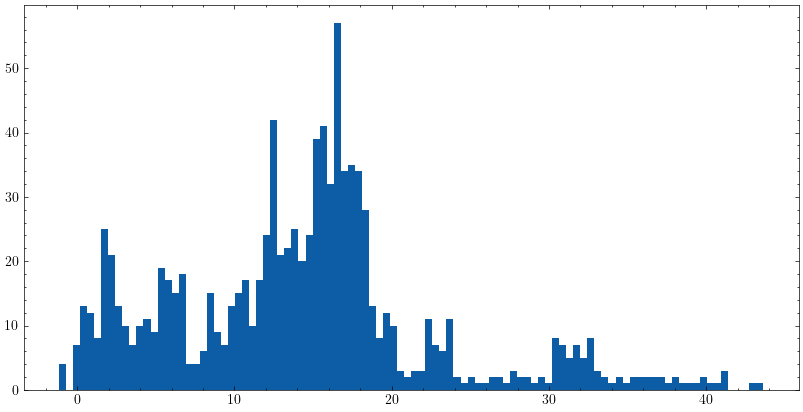

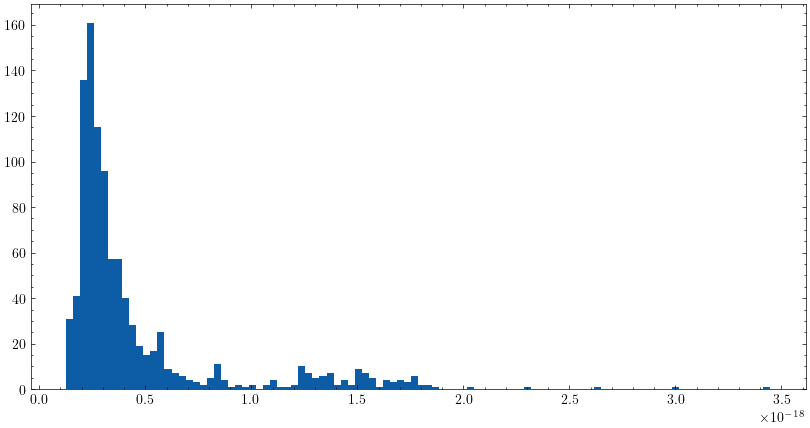

In [6]:
snr = absSpectrumTable['flux'] / absSpectrumTable['flux_error']
print(np.mean(snr))
plt.figure(figsize=(10, 5))
plt.hist(snr, bins=100)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(absSpectrumTable['flux_error'], bins=100)
plt.show()

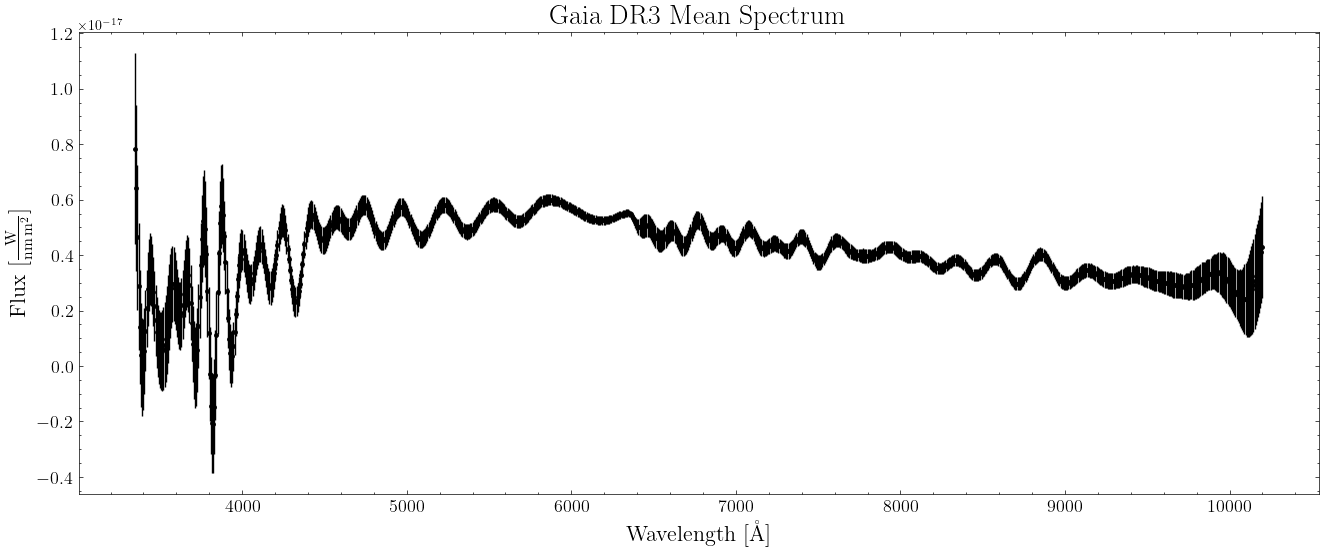

In [7]:
PLOT_INTERVAL = 1
plt.figure(figsize=(16, 6))
with astropy.visualization.quantity_support():
    plt.errorbar(absSpectrumTable['wavelength'][::PLOT_INTERVAL], absSpectrumTable['flux'][::PLOT_INTERVAL], absSpectrumTable['flux_error'][::PLOT_INTERVAL], marker='.', ls='none', markersize=5, color='black')
    plt.xlabel(f"Wavelength [{absSpectrumTable['wavelength'].unit._repr_latex_()}]", fontsize=16)
    plt.ylabel(f"Flux [{absSpectrumTable['flux'].unit._repr_latex_()}]", fontsize=16)
    plt.tick_params(axis='both', labelsize=13)
    plt.title("Gaia DR3 Mean Spectrum", fontsize=20)
    # plt.xscale('log')
    plt.show()

# Interstellar Extinction

## Bayestar $E(B - V)$

In [8]:
import dustmaps
from dustmaps.config import config
config['data_dir'] = '/home/ramon/.dustmaps/maps'

import dustmaps.bayestar
dustmaps.bayestar.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [9]:
import astropy.units as u
from astropy.coordinates import SkyCoord

objCoord = SkyCoord.from_name('ATO J339.9469+45.1464')
objCoord = SkyCoord(objCoord.ra, objCoord.dec, frame=objCoord.frame, distance=2256.9956*u.pc) # distance taken from Bailer (sp?) et aL.
# objCoord = SkyCoord(objCoord.ra, objCoord.dec, frame=objCoord.frame)
objCoord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (339.94690379, 45.14639753, 2256.9956)>

In [10]:
from dustmaps.bayestar import BayestarQuery

bayestar = BayestarQuery(max_samples=50)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 23.705 s
  pix_info:   0.297 s
   samples:  13.632 s
      best:   2.770 s
       nan:   0.012 s
      sort:   6.927 s
       idx:   0.068 s


In [11]:
ebv, flags = bayestar(objCoord, mode='samples', return_flags=True)
ebv

array([0.16, 0.14, 0.13, 0.14, 0.13], dtype=float32)

## FM90 extinction curve

Using [Savage et al. (1985)](https://ui.adsabs.harvard.edu/abs/1985ApJS...59..397S/abstract) measured extinction for line of sight. Adjusting individual terms for extinction law.

In [12]:
from astropy.coordinates import FK4

# for reference in text table in Savage et al. (1985) (1950 epoch)
objCoord.transform_to(frame=FK4).to_string('hmsdms')

'22h37m36.70362313s +44d53m07.37303923s'

In [13]:
# obj for reference: 214240
refCoord = SkyCoord("22:33:48 +49:48.7", distance=320*u.pc, frame=FK4, unit=(u.hourangle, u.deg))
refCoord, objCoord.transform_to(frame=FK4)

(<SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec, distance) in (deg, deg, pc)
     (338.45, 49.81166667, 320.)>,
 <SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec, distance) in (deg, deg, pc)
     (339.40293176, 44.8853814, 2256.9956)>)

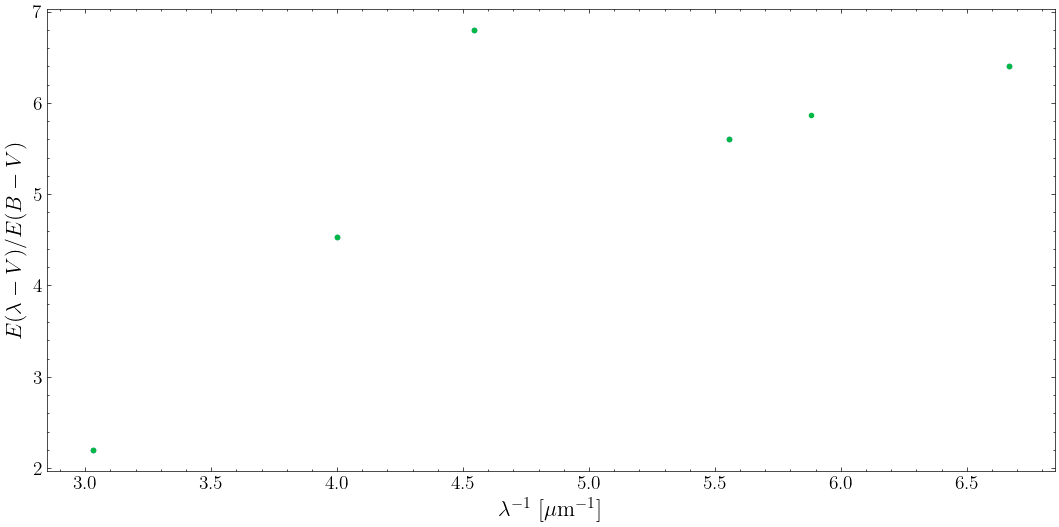

In [18]:
from scipy.interpolate import interp1d

ref_ebv = 0.15
ref_excess = np.array([0.33, 0.68, 1.02, 0.84, 0.96])
ref_wavelens = np.array([33, 25, 22, 18, 15]) * 100 * u.angstrom

ref_wavelens_interp = interp1d(ref_wavelens, ref_excess)
ref_wavelens_stretch = np.array([15, 17, 18, 22, 25, 33]) * 100 * u.angstrom
ref_excess_stretch = ref_wavelens_interp(ref_wavelens_stretch)

plt.figure(figsize=(13, 6))
plt.plot(1/ref_wavelens.to(u.micron), ref_excess/ref_ebv, linestyle='none', marker='.')
plt.plot(1/ref_wavelens_stretch.to(u.micron), ref_excess_stretch/ref_ebv, linestyle='none', marker='.')
plt.ylabel(r"$E(\lambda - V) / E(B - V)$", fontsize=16)
plt.xlabel(rf"$\lambda^{{-1}}$ [{u.micron._repr_latex_()}$^{{-1}}$]", fontsize=16)
plt.tick_params(axis='both', labelsize=14)

/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
/tmp/ipykernel_129857/2928026044.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  bestParams, covar = curve_fit(ext_model, wav, ref_excess_stretch/ref_ebv, p0=[2, 2, 7, 3, 4.5, 0.7]) # initial guess by eye


array([-1.71570846,  1.24269321,  1.9110984 , -0.88193511,  4.44203175,
        0.79040726])

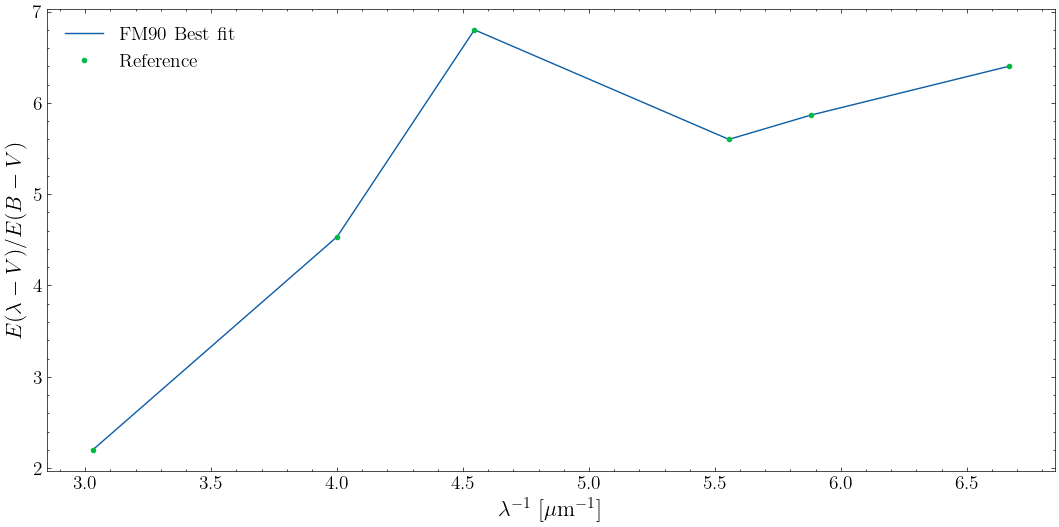

In [22]:
from scipy.optimize import curve_fit
from dust_extinction.parameter_averages import FM90

def ext_model(wavelens, linear_yintercept, linear_slope, bump_strength, fuv_rise_amplitude, bump_centroid, bump_width):
# def ext_model(wavelens, linear_yintercept, linear_slope, fuv_rise_amplitude, bump_centroid, bump_width):
    ext = FM90(C1=linear_yintercept,
               C2=linear_slope,
               C3=bump_strength,
            #    C3=0.29,
               C4=fuv_rise_amplitude,
               xo=bump_centroid,
               gamma=bump_width)
    return ext(wavelens)

wav = 1/ref_wavelens_stretch.to(u.micron)
bestParams, covar = curve_fit(ext_model, wav, ref_excess_stretch/ref_ebv, p0=[2, 2, 7, 3, 4.5, 0.7]) # initial guess by eye

ext = FM90(C1=bestParams[0], 
           C2=bestParams[1],
           C3=bestParams[2],
           C4=bestParams[3],
           xo=bestParams[4],
           gamma=bestParams[5])
plt.figure(figsize=(13, 6))
plt.plot(wav, ext(wav), label=f"FM90 Best fit")
plt.plot(1/ref_wavelens_stretch.to(u.micron), ref_excess_stretch/ref_ebv, linestyle='none', marker='.', label='Reference')
plt.ylabel(r"$E(\lambda - V) / E(B - V)$", fontsize=16)
plt.xlabel(rf"$\lambda^{{-1}}$ [{u.micron._repr_latex_()}$^{{-1}}$]", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)
bestParams

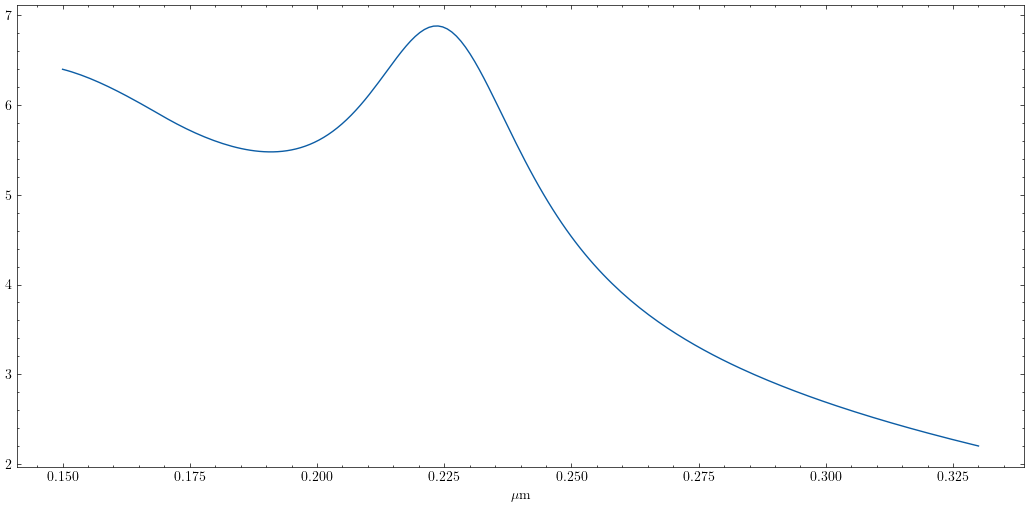

In [83]:
completeWavelens = np.linspace(start=15, stop=33, num=201, endpoint=True) * 100 * u.angstrom

plt.figure(figsize=(13, 6))
plt.plot(completeWavelens.to(u.micrometer), ext(completeWavelens))

## Alternate extinction curve

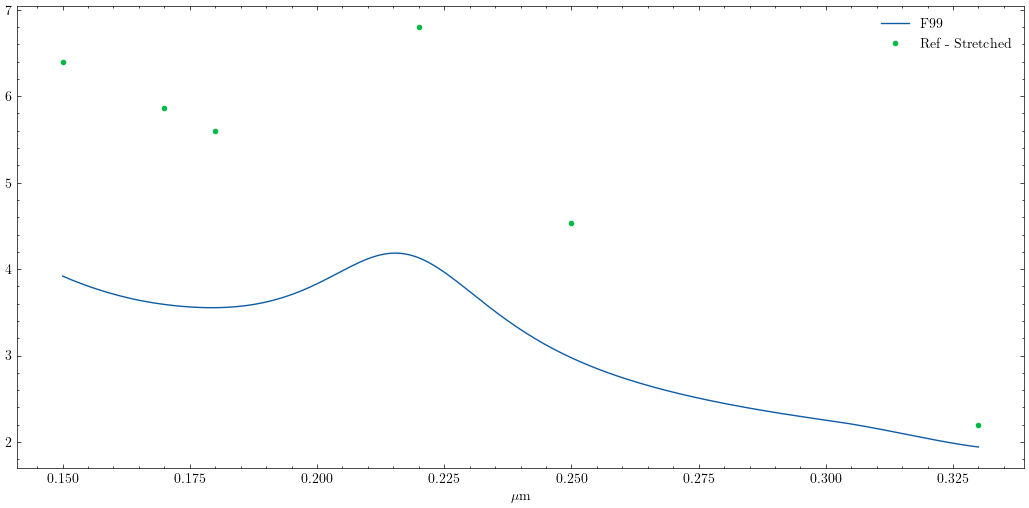

In [87]:
from dust_extinction.parameter_averages import F99, G23
from dust_extinction.averages import G21_MWAvg

astropy.visualization.quantity_support()

# ext_f99 = F99(Rv=3.1)
alt_ext = G23(Rv=2.3)
plt.figure(figsize=(13, 6))
plt.plot(completeWavelens.to(u.micrometer), alt_ext(completeWavelens), label='F99')
plt.plot(ref_wavelens_stretch.to(u.micron), ref_excess_stretch/ref_ebv, linestyle='none', marker='.', label='Ref - Stretched')
plt.legend()

# Deredden Gaia spectrum

Using FM90 model adjusted to excess colors for standard star in ATO object line of sight.

In [54]:
absSpectrumTable

wavelength,flux,flux_error
nm,W / (nm m2),W / (nm m2)
float64,float64,float64
335.0,7.837949406045415e-18,3.447813615423258e-18
335.6856856856857,6.413392679202196e-18,3.003305875762241e-18
336.37137137137137,4.641329396436622e-18,2.6210598929227357e-18
337.0570570570571,2.873712375051093e-18,2.295838052378454e-18
337.74274274274273,1.4039391711452228e-18,2.0521700501221794e-18
338.42842842842845,4.069976640569461e-19,1.882319105821718e-18
339.1141141141141,-3.66090860849301e-20,1.7584083657585505e-18
339.7997997997998,4.6584361645511226e-20,1.650221731450818e-18
